In [1]:
from LorenzEDMD.EDMD.EDMD import EDMD_CHEB
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
import pickle
from LorenzEDMD.utils.data_processing import (
    normalise_data_chebyshev, 
    get_acf,
    Koopman_correlation_function,
    )
from LorenzEDMD.dynamical_system.Lorenz import lorenz63
from LorenzEDMD.EDMD.EDMD import TSVD
import matplotlib
import plotly.graph_objects as go
from tqdm import tqdm
from LorenzEDMD.utils.paths import get_data_folder_path

matplotlib.rcParams.update({
    "text.usetex": True,  # Use LaTeX to render text
    "font.family": "serif",  # Use serif font (default in LaTeX)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: better math support
})

In [2]:
data_path = get_data_folder_path()
f_name = "edmd_smalldt.pkl"#"edmd_prova.pkl"

with open(data_path / f_name,"rb") as f:
    results = pickle.load(f)

EDMDS : List[List[EDMD_CHEB]] = results["edmd results"]
lorenz : lorenz63 = results["lorenz settings"] 

degrees = [x[0].degree for x in EDMDS]
flight_times = [x.flight_time for x in EDMDS[0]]

#### Fix a degree, regularise and get spectral properties

In [3]:
degree_number = -3
degree = degrees[degree_number] 
edmd_flight_times = EDMDS[degree_number]
edmd : EDMD_CHEB = edmd_flight_times[0] 
print(degree)

18


In [4]:
# Regularisation with TSVDS
tsvd_regulariser = TSVD(rel_threshold=1e-5)
Kreduced = tsvd_regulariser.decompose(edmd)

# Get spectral properties
tsvd_regulariser.get_spectral_properties()
lambdas = np.log(tsvd_regulariser.eigenvalues) / ( lorenz.dt * lorenz.tau * edmd.flight_time)


#### Evaluate correlation functions for Koopman Eigenfunctions

In [5]:
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 10
lorenz_cf_traj.t_span = (0,10000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

100%|██████████| 10000000/10000000 [01:28<00:00, 113128.86it/s]


In [6]:
PHI_TRAJ = edmd.evaluate_koopman_eigenfunctions_reduced(scaled,tsvd_regulariser)

In [7]:
numbers = [1,3,4,6,8]
nlags = 1500
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time

/Users/niccolo/Desktop/Response_Lorenz_Koopman/.venv/lib/python3.10/site-packages/numpy/_core/_asarray.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)


Text(0.5, 0, '$t$')

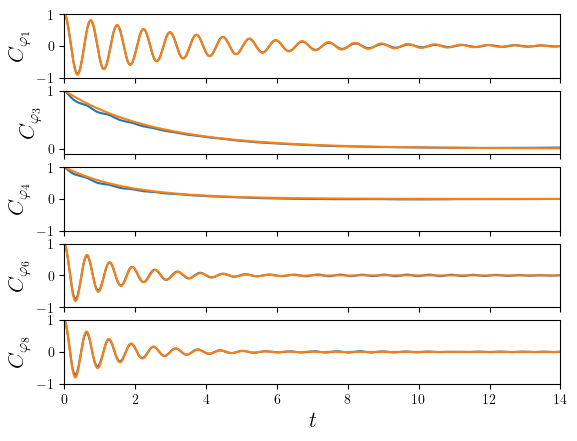

In [8]:
fig , ax = plt.subplots(len(numbers),sharex=True)

for i,number in enumerate(numbers):
    lags, cf = get_acf(PHI_TRAJ[:,number], nlags = nlags,Dt=Dt)
    cf_th = np.real(np.exp(lambdas[number]*lags))
    ax[i].plot(lags,cf/cf[0])
    ax[i].plot(lags,cf_th /cf_th[0] )
    ax[i].set_xlim(0,14)
    
    ax[i].set_ylim(-1,1)
    if i ==1 :
        ax[i].set_ylim(-0.1,1)
    ax[i].set_ylabel(fr"$C_{{ \varphi_{number} }}$",size=16)
ax[-1].set_xlabel("$t$",size=16)    
#fig.savefig("Correlation_function_Koopman_eigenfunctions.png",dpi=600)

(0.0, 15.0)

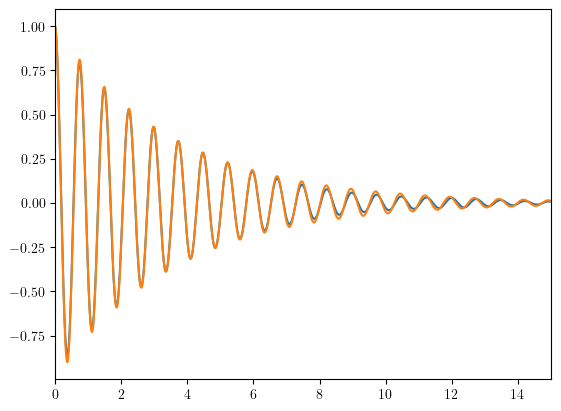

In [9]:
fig , ax = plt.subplots()

number = 1
lags, cf = get_acf(PHI_TRAJ[:,number], nlags = nlags,Dt=Dt)
cf_th = np.real(np.exp(lambdas[number]*lags))
ax.plot(lags,cf/cf[0])
ax.plot(lags,cf_th /cf_th[0] )
ax.set_xlim(0,15)

### Evaluate correlation functions of observables

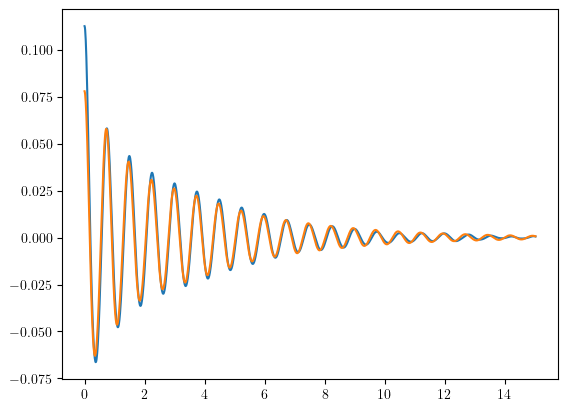

In [17]:
decompositions = edmd.get_decomposition_observables()
projections_dictionary = decompositions["z"]
nlags = 1500
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time
# Project in the r-dimensional space
Gr = np.diag(tsvd_regulariser.Sr)
G_koop_r = tsvd_regulariser.reduced_right_eigvecs.T.conj() @ Gr @ tsvd_regulariser.reduced_right_eigvecs
projections_reduced = tsvd_regulariser.Ur.T @ projections_dictionary

# Thresholding on a subset of modes
tau_threshold = -1.5
indx = np.where(np.real(lambdas) > tau_threshold)[0] 
lambdas_good = lambdas[indx]

# Projection onto the subspace spanned by the leading n selected modes
Vn = tsvd_regulariser.reduced_right_eigvecs[:,indx]
G_koop_n = Vn.T.conj() @ Gr @ Vn
fn =  np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr @ projections_reduced

# Old projection
fnOld = tsvd_regulariser.reduced_left_eigvecs.T.conj() @ projections_reduced

# Numerical correlation function
lags, cf = get_acf(scaled[:,2], nlags = nlags,Dt=Dt)
# Spectral Reconstruction
K_corr_proj = lambda t: Koopman_correlation_function(t,G_koop_n,fn,fn,lambdas_good )
cf_koop = np.real([K_corr_proj(lag) for lag in lags])


fig, ax = plt.subplots()
ax.plot(lags,cf)
ax.plot(lags,cf_koop)

(0.0, 13.0)

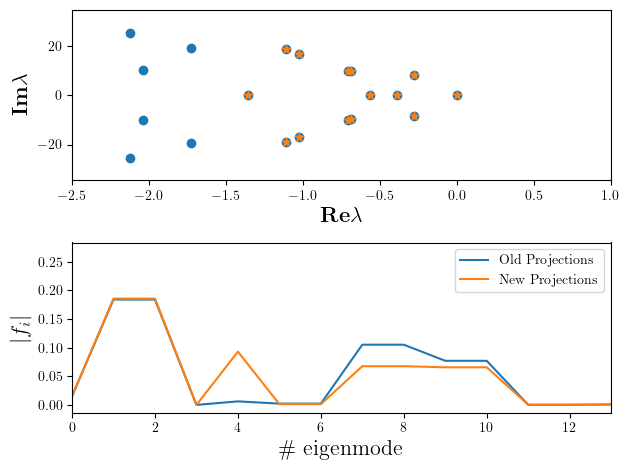

In [18]:
fig, ax = plt.subplots(nrows=2)
ax[0].scatter(np.real(lambdas),np.imag(lambdas))
ax[0].scatter(np.real(lambdas_good), np.imag(lambdas_good),marker="*")
ax[0].set_xlabel(r"$\mathbf{Re}\lambda$",size=16)
ax[0].set_ylabel(r"$\mathbf{Im}\lambda$",size=16)
ax[0].set_xlim(-2.5,1)

ax[1].plot(np.abs(fn),label="Old Projections")
ax[1].plot(np.abs(fnOld), label = "New Projections")
ax[1].legend()
ax[1].set_xlabel(r"\# eigenmode",size=16)
ax[1].set_ylabel(r"$|f_i|$",size=16)
fig.tight_layout()
ax[1].set_xlim(0,indx[-1])
#fig.savefig("Projections_high.png",dpi=600)

NameError: name 'get_koopman_coefficients' is not defined

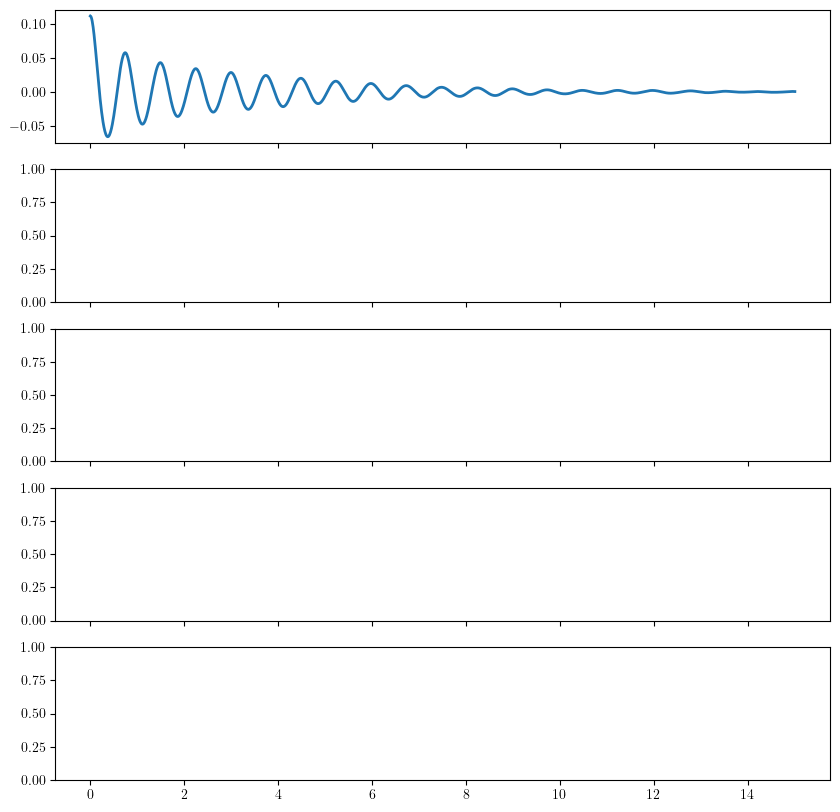

In [19]:
fig, ax = plt.subplots(figsize=(10,10),nrows = len(decompositions),sharex=True)
x,y,z = scaled[:,0] , scaled[:,1] , scaled[:,2]
observables = [z,x**2,y**2,z**2,x*y]
strings = ["C_{"+key+"}(t)" for key, _ in decompositions.items() ]
for (index, (key , projections_dictionary) ) in enumerate(decompositions.items()):
    lags, cf = get_acf(observables[index], nlags = nlags,Dt=Dt)
    ax[index].plot(lags,cf,linewidth=2)

    lambdas_good, G_koop_n, fn = get_koopman_coefficients(projections_dictionary)
    K_corr_proj = lambda t: Koopman_correlation_function(t,G_koop_n,fn,fn,lambdas_good )
    ax[index].plot(lags,np.real([K_corr_proj(lag) for lag in lags]))
    ax[index].set_ylabel(f"${strings[index]}$",size=16)

ax[-1].set_xlabel("$t$",size=18)
ax[-1].set_xlim(-0.5,12)
# fig.savefig("Autocorrelation_functions.png",dpi=600)

In [ ]:
#K_corr_old = lambda t: Koopman_correlation_function(t,G_koop_r,fnOld,fnOld,lambdas,to_include=len(lambdas_good))

K_corr_proj = lambda t: Koopman_correlation_function(t,G_koop_n,fn,fn,lambdas_good )

In [ ]:

lags, cf = get_acf(z**2, nlags = nlags,Dt=Dt)
plt.plot(lags,cf  ,label="Time series",linewidth=2)
#plt.plot(lags,np.real( [K_corr_old(lag) for lag in lags])   ,label="Old Koopman")
plt.plot(lags,np.real([K_corr_proj(lag) for lag in lags]), label = "Koopman")

plt.xlim(-1,15)
plt.xlabel(r"$t$",size=16)
plt.ylabel(r"$C_{z}(t)$",size=16)
plt.legend()
#plt.ylim(-0.2,0.2)
#plt.savefig("Correlation_function_z_comparison.png",dpi=600)

In [ ]:
# x,y,z = X[:,0] , X[:,1] , X[:,2]
# lags, cf = get_acf(z, nlags = nlags,Dt=Dt)
# Ckoop = np.array( [np.real(K_corr_proj(lag)) for lag in lags] )
# zmin, zmax = data_min[-1] , data_max[-1]
# scale = (zmax - zmin) / 2
# plt.plot(lags,cf )
# plt.plot(lags,Ckoop * scale**2, label = "Koopman")

# Numerical Projections
We compare different projections (Lebesgue, invariant measure, exact) for the evaluation of correlation properties

In [20]:
### EVALUATE INVARIANT MEASURE

lorenz_resp_traj = lorenz63()
lorenz_resp_traj.noise = lorenz.noise
lorenz_resp_traj.tau = 2
lorenz_resp_traj.t_span = (0,100000)

t, X = lorenz_resp_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

L = 100
hist, edges = np.histogramdd(scaled, bins= [int(L)]*3,density=True)
x_centers = 0.5 * (edges[0][1:] + edges[0][:-1])
y_centers = 0.5 * (edges[1][1:] + edges[1][:-1])
z_centers = 0.5 * (edges[2][1:] + edges[2][:-1])

dx = edges[0][1] - edges[0][0]
dy = edges[1][1] - edges[1][0]
dz = edges[2][1] - edges[2][0]
dV = dx * dy * dz

# Build the full grid
Xg, Yg, Zg = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")
grid_points = np.stack([Xg.ravel(), Yg.ravel(), Zg.ravel()], axis=1)

# Check the normalisation
print(sum(hist).sum().sum() * dV)

# Compute marginal density in the xz-plane by integrating out y
marginal_xz = np.sum(hist, axis=1) * dy  # integrate over y-axis
marginal_xz[marginal_xz < 1e-4] = np.nan
# Create the meshgrid for plotting
X_plot, Z_plot = np.meshgrid(x_centers, z_centers, indexing="ij")

# Plot the marginal density
plt.figure(figsize=(8, 6))
plt.pcolormesh(X_plot, Z_plot, marginal_xz, shading='auto',cmap="inferno")
plt.xlabel('$x$',size=26)
plt.ylabel('$z$',size=26)
plt.tight_layout()
del X , scaled

 16%|█▋        | 16493825/100000000 [02:25<12:19, 112985.79it/s]


KeyboardInterrupt: 

In [ ]:
# Define an observable on the grid
obs = Zg 

### Projection with Lebesgue

In [ ]:
# Evaluate the Gram matrix for Lebesgue products
if 'G_Lebesgue' not in globals():
    Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_points)
    G_Lebesgue = (Psi_Lebesgue.T @ (Psi_Lebesgue * dV)) 
print(np.linalg.cond(G_Lebesgue))

In [ ]:
# Project the observable using Lebesgue projections
obs_vals = obs.ravel()
scalar_products = Psi_Lebesgue.T @ (obs_vals * dV)
full_state_coefficients_lebesgue = np.linalg.pinv(G_Lebesgue) @ scalar_products

# If inverting G is problematic, one can regularise it with Truncated Singular Value Decomposition
# U, S, Vt = np.linalg.svd(G_Lebesgue, full_matrices=False) 
# r = np.sum(S > 1e-4 *S[0])
# Ur = U[:,:r] 
# Sr_inv = np.diag(1 / S[:r])
# Gpinv = Ur @ Sr_inv @ Ur.T
#full_state_coefficients_lebesgue = Gpinv @ scalar_products

### Projections with respect to the invariant density

In [ ]:
# Thresholding only where the invariant measure is significantly different from zero
hist_flat = hist.ravel()
threshold = np.percentile(hist_flat,94)  
mask = hist_flat >= threshold
relevant_grid_points = grid_points[mask]
hist_vals = hist_flat[mask] 
print(len(hist_vals), threshold)

Psi_Inv_Measure = edmd.evaluate_dictionary_batch(relevant_grid_points)

In [ ]:
# Project according to the invariant measure
obs_vals = obs.ravel()[mask]
scalar_products_invariant_measure = Psi_Inv_Measure.T @ (obs_vals * dV * hist_vals)
full_state_coefficients_invariant_measure =  (tsvd_regulariser.Ur @ np.diag( 1 / (tsvd_regulariser.Sr + 0.001)) @ tsvd_regulariser.Ur.T  ) @ scalar_products_invariant_measure

In [ ]:
# Getting into the reduced r-space
reduced_state_coefficients_lebesgue = tsvd_regulariser.Ur.T @ full_state_coefficients_lebesgue
reduced_state_coefficients_invariant_measure = tsvd_regulariser.Ur.T @ full_state_coefficients_invariant_measure

In [ ]:
# Getting into the Koopman space
project_to_koopman_space = np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr
koopman_coefficients_lebesgue = project_to_koopman_space @ reduced_state_coefficients_lebesgue
koopman_coefficients_invariant_measure = project_to_koopman_space @ reduced_state_coefficients_invariant_measure

In [ ]:
fig, ax = plt.subplots(nrows=3)

ax[0].plot(np.real(fn),alpha=0.6)
ax[0].plot(np.real(koopman_coefficients_lebesgue),'.')
ax[0].plot(np.real(koopman_coefficients_invariant_measure),'.' )

ax[1].plot(np.imag(fn),alpha=0.6)
ax[1].plot(np.imag(koopman_coefficients_lebesgue),'.')
ax[1].plot(np.imag(koopman_coefficients_invariant_measure),'.')

ax[-1].plot(np.abs(fn),alpha=0.6)
ax[-1].plot(np.abs(koopman_coefficients_lebesgue),'.')
ax[-1].plot(np.abs(koopman_coefficients_invariant_measure),'.' )

In [ ]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(full_state_coefficients_lebesgue,label="Lebesgue")
ax[0].plot(full_state_coefficients_invariant_measure,alpha=0.5,label="Invariant Measure")
ax[0].legend()

ax[1].plot(reduced_state_coefficients_lebesgue,label="Lebesgue")
ax[1].plot(reduced_state_coefficients_invariant_measure,alpha=0.5,label="Invariant Measure")
ax[1].legend()

ax[-1].plot(np.abs(fn),alpha=0.6,color='green',label="From Exact Decomposition")
ax[-1].plot(np.abs(koopman_coefficients_lebesgue),'.',label="Lebesgue")
ax[-1].plot(np.abs(koopman_coefficients_invariant_measure),'.', label="Invariant Measure" )
ax[-1].legend()

#fig.savefig("Projections.png",dpi=600)

In [ ]:
koopman_coefficients = {
    "Exact" : fn,
    "Lebesgue": koopman_coefficients_lebesgue,
    "Invariant Measure" : koopman_coefficients_invariant_measure
}

In [ ]:
### From time series
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 100
lorenz_cf_traj.t_span = (0,50000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

xmax , ymax, zmax = data_max
xmin, ymin, zmin = data_min
scale = (zmax - zmin) / 2 

scale = {
    "x" : (xmax - xmin) / 2 , 
    "y" : (ymax - ymin) / 2,
    "z" : (zmax- zmin) / 2,
    "x^2" : ( (xmax - xmin) / 2 )**2,
    "y^2" : ((ymax - ymin) / 2)**2,
    "z^2" : ((zmax- zmin) / 2) **2,
    "xy" : (xmax - xmin) / 2 * (ymax - ymin) / 2
}

In [ ]:
batch_size = 100_000
n_total = scaled.shape[0]
range_batches = range(0, n_total, batch_size)
n_batches = len(range_batches)

# Optional: get output shape from one batch
example = edmd.evaluate_dictionary_batch(scaled[:1, :])
avgs = np.zeros(example.shape[1])

for i in tqdm(range_batches):
    batch = scaled[i:min(i + batch_size, n_total), :]
    Psi_trajectory = edmd.evaluate_dictionary_batch(batch)
    x_traj = batch[:, 0]
    avgs += np.mean(x_traj[:, None] * Psi_trajectory, axis=0)

avgs /= n_batches


In [ ]:
# Thresholding on a subset of modes
tau_threshold = -1
indx = np.where(np.real(lambdas) > tau_threshold)[0] 
lambdas_good = lambdas[indx]

# Projection onto the subspace spanned by the leading n selected modes
Vn = tsvd_regulariser.reduced_right_eigvecs[:,indx]
G_koop_n = Vn.T.conj() @ Gr @ Vn
project_to_koopman_space = np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr
fn =  project_to_koopman_space @ projections_reduced

In [ ]:
# Working in full space
Ay = edmd.build_derivative_matrix(direction=1)
scalar_product_Gamma = Ay.T @ avgs
Gamma_projections = (tsvd_regulariser.Ur @ np.diag( 1 / (tsvd_regulariser.Sr + 0.01)) @ tsvd_regulariser.Ur.T  ) @ scalar_product_Gamma
reduced_Gamma = tsvd_regulariser.Ur.T @ Gamma_projections
koopman_Gamma = project_to_koopman_space @ reduced_Gamma

# Working just in reduced space
reduced_der_operator = tsvd_regulariser.Ur.T @ Ay.T @ tsvd_regulariser.Ur
reduced_delta = tsvd_regulariser.Ur.T @ avgs
reduced_Gamma_2 = np.diag( 1 / (tsvd_regulariser.Sr + 0.001 )) @ reduced_der_operator @ reduced_delta
koopman_Gamma_2 = project_to_koopman_space @ reduced_Gamma_2

# Derivative operator in Koopman
P_koop = Vn @ project_to_koopman_space


In [ ]:
fig , ax = plt.subplots(nrows=3,sharex=True,figsize= (10,10))
ax[0].plot(avgs)
ax[1].plot(scalar_product_Gamma)
ax[2].plot(Gamma_projections)

In [ ]:
plt.plot(reduced_delta)
plt.plot(reduced_der_operator @ reduced_delta)

In [ ]:
fig, ax  = plt.subplots(nrows=2)
ax[0].plot(reduced_Gamma)
ax[0].plot(reduced_Gamma_2)
ax[1].plot(np.abs(koopman_Gamma))
ax[1].plot(np.abs(koopman_Gamma_2))

In [ ]:
f_name = "response_cluster.pkl"
with open(data_path/f_name,"rb") as f:
    response = pickle.load(f)

RP = response["Positive Response"]
RM = response["Negative Response"]
amplitudes = response["Amplitudes"]

Gs = []
for rp, rm, eps in zip(RP,RM,amplitudes):
    G = (rp -rm) / (2*eps)
    Gs.append(G)
# response["Positive Response"]

observable_index = {
    "x" : 0,
    "y" : 1,
    "z" : 2,
    "x^2" : 3,
    "y^2" : 4,
    "z^2" : 5
}

tspan = response["Response Settings"].t_span 
t = np.arange(tspan[0],tspan[-1],response["Response Settings"].dt )
tresp = t[::response["Response Settings"].tau]

G = np.zeros(Gs[0].shape)
for g in Gs:
    G += g / len(Gs)

In [ ]:
lambdas_good,G_koop_n, fn = get_koopman_coefficients(decompositions["z"])

Gkoop = lambda t: Koopman_correlation_function(t,G_koop_n,fn_z,koopman_Gamma_2,lambdas_good )
Gkoop = np.array( [np.real( Gkoop(lag) ) for lag in lags] )
GreenKoopPhysicalSpace = Gkoop*scale["z"]
plt.plot(tresp,G[:,observable_index["z"]],label="Numerics")
plt.plot(lags[1:],GreenKoopPhysicalSpace[1:], label="Koopman Reconstruction") 
plt.xlim(-1,15)
plt.grid('--',alpha=0.2)
plt.xlabel("$t$",size=18)
plt.ylabel("$G_z(t)$",size=18)
plt.legend()
#plt.xlim(-1,1)
#plt.savefig("Koopman_Reconstruction_Green_Function_18.png",dpi=500)


In [ ]:
from scipy.io import savemat

Data = {
    't_response_numerical': tresp,
    'Green_function_numerical' : G[:,observable_index["z"]],
    't_response_koopman' : lags[1:],
    'Green_function_koopman ' : GreenKoopPhysicalSpace[1:]
}

savemat('Response_Lorenz_Z.mat',Data)


In [ ]:
data_path = get_data_folder_path()
fname = 'Green_Function_Koopman_Z_porcodio.txt'
np.savetxt(data_path/fname,GreenKoopPhysicalSpace[1:])

In [ ]:
lambdas_good,G_koop_n, fn = get_koopman_coefficients(decompositions["z"])

Gkoop = lambda t: Koopman_correlation_function(t,G_koop_n,fn,koopman_Gamma_2,lambdas_good )
Gkoop = np.array( [np.real( Gkoop(lag) ) for lag in lags] )
plt.plot(tresp,G[:,observable_index["z"]],label="Numerics")
plt.plot(lags,Gkoop*scale["z"], label="Koopman Reconstruction") 
plt.xlim(-1,15)
plt.grid('--',alpha=0.2)
plt.xlabel("$t$",size=18)
plt.ylabel("$G_z(t)$",size=18)
plt.legend()
#plt.xlim(-1,1)
#plt.savefig("Koopman_Reconstruction_Green_Function_18.png",dpi=500)